# Approach 3: VQE Simulation

## 0 | Setup

In [18]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# import Qiskit libraries
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimators

In [19]:
your_api_key = "bgrJ_6-zK6kQSt78RJydUP2I1YQKbDtkE7UysTKLNhXN"
your_crn = "crn:v1:bluemix:public:quantum-computing:us-east:a/d4f95db0515b47b7ba61dba8a424f873:e27020ce-4df5-4d23-a715-188a850e36c9::"
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=your_api_key,
    instance=your_crn,
    overwrite=True
)

In [20]:
from qiskit_ibm_catalog import QiskitFunctionsCatalog
 
catalog = QiskitFunctionsCatalog(
    channel="ibm_quantum_platform",
    instance = your_crn,
    token = your_api_key,
)
 
# Access Function
perf_mgmt = catalog.load("q-ctrl/performance-management")

In [ ]:
# # how to use qctrl
# sampler_pub = [(qc,)]

# qctrl_sampler_job = perf_mgmt.run(
#     primitive = "sampler", 
#     pubs = sampler_pub)

## 1 | Hamiltonian
#### **Hamiltonian: Ising Model (4 Qubits)**

The transverse-field Ising model Hamiltonian for 4 qubits is given by:


$$
\begin{align*}
H &= h \sum_{i=0}^{3} Z_i + J \sum_{i=0}^{2} Z_i Z_{i+1}
\\&
= (\text{field terms}) + (\text{interaction terms})
\end{align*}
$$

where:
- $h$ = transverse field strength
- $J$ = coupling constant
- $Z_i$ = Pauli-Z operator acting on qubit \(i\)

### Hamiltonian

In [4]:
from qiskit.quantum_info import SparsePauliOp

def build_ising_hamiltonian(n_qubits, h = 1.0, J = 1.0, periodic=False):
    """
    Build Ising Hamiltonian: 
    H = h Σ Z_i + J Σ Z_i Z_{i+1}
    
    Args:
        n_qubits (int): number of qubits
        h (float): transverse field strength (Z_i)
        J (float): coupling strength (Z_i Z_{i+1})
        periodic (bool): add Z_{N-1} Z_0 term for periodic boundary
    
    Returns:
        SparsePauliOp: Hamiltonian operator
    """
    
    def pauli_string_z(n, qubits):
        """Create a Pauli string for Z operators on specified qubits.""" # express Hamiltonian in terms of Pauli gates/operators
        s = ['I'] * n
        for q in qubits:
            s[q] = 'Z'
        return ''.join(s)

    pauli_terms = [] # list for terms in the Hamiltonian
    
    # Transverse field: h * Z_i
    for i in range(n_qubits):
        pauli_terms.append( (pauli_string_z(n_qubits, [i]), h) )
    
    # Nearest-neighbor interactions: J * Z_i Z_{i+1}
    for i in range(n_qubits - 1):
        pauli_terms.append( (pauli_string_z(n_qubits, [i, i+1]), J) )
    
    if periodic:
        pauli_terms.append( (pauli_string_z(n_qubits, [n_qubits-1, 0]), J) )
    
    # Build SparsePauliOp
    hamiltonian = SparsePauliOp.from_list(pauli_terms)
    return hamiltonian

In [5]:
# construct Hamiltonian by specified paramaeters

# parameters
n_qubits = 4 
h = 1.0
J = 1.0

# create Ising Hamiltonian
H = build_ising_hamiltonian(n_qubits, h, J, periodic=False)
print(H)

SparsePauliOp(['ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'IZZI', 'IIZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


## 2 | Ansatz (Quantum Circuit)
For now, use a standard VQE quantum circuit called "TwoLocal".

**Source**: Kandala et al., Nature 549, 242–246 (2017)
Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets.
DOI: 10.1038/nature23879

/var/folders/2h/t411d17d6jj2cw0g5vgr_jn80000gn/T/ipykernel_30301/224811712.py:6: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz = TwoLocal(


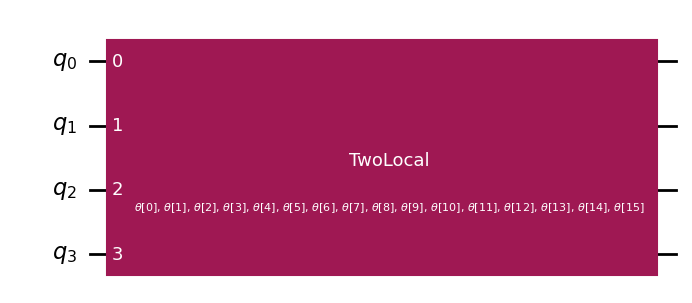

In [6]:
from qiskit.circuit.library import TwoLocal

n_qubits = 4

# Define the ansatz (quantum circuit)
ansatz = TwoLocal(
    num_qubits=n_qubits,
    rotation_blocks='ry',         # single‑qubit rotations: Ry
    entanglement_blocks='cz',     # two‑qubit entanglement: CZ gates
    entanglement='linear',        # linear (nearest‑neighbor) entanglement
    reps=3,                        # number of layers (depth)
    parameter_prefix=r'$\theta$'          # name of parameters
)

# Draw the ansatz circuit (overall)
ansatz.draw("mpl")

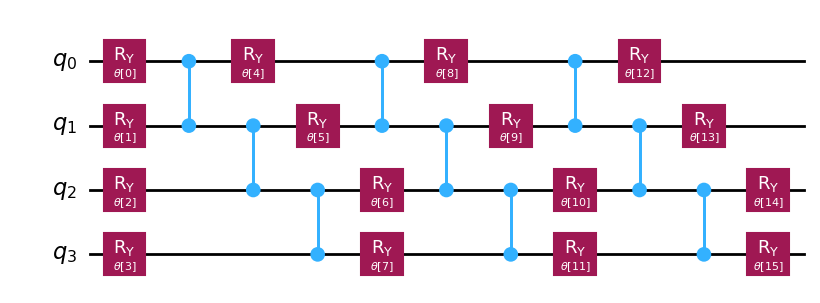

In [7]:
# Draw the ansatz circuit (decomposed)
ansatz.decompose().draw("mpl")

In [8]:
print(f"Number of parameters in ansatz: {len(ansatz.parameters)}")

Number of parameters in ansatz: 16


## 3 | Estimator (backend)

### State vector estimator (perfect processing)

In [9]:
from qiskit_aer.primitives import Estimator
estimator = Estimator()

In [10]:
# from qiskit.primitives import Estimator
# from qiskit_aer import AerSimulator

# # create AerSimulator backend
# aer_simulator = AerSimulator()

# # create Estimator tied to AerSimulator
# estimator = Estimator(backend=aer_simulator)

In [11]:
from qiskit_aer import AerSimulator

aer_sim = AerSimulator()
# pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
# isa_qc = pm.run(qc)
# with Session(backend=aer_sim) as session:
#     sampler = Sampler(mode=session)
#     result = sampler.run([isa_qc]).result()

## 4 | Cost function

In [12]:
# # cost function for VQE
# def original_cost_fn(params, ansatz, hamiltonian, estimator):
#     """    
#     Inputs: 
#     - params: parameters for the ansatz
#     - ansatz: quantum circuit ansatz
#     - hamiltonian: Ising Hamiltonian operator
#     - estimator: Qiskit Estimator for running circuits
    
#     Returns:
#     - energy: expectation value of the Hamiltonian
#     """
#     qc = ansatz.assign_parameters(params) # must bind parameters to the ansatz (??)
#     result = estimator.run([qc], [hamiltonian]).result()
#     energy = result.values[0] # first value is the expected energy
#     return energy

# from functools import partial

# cost_fn = partial(original_cost_fn, ansatz=ansatz, hamiltonian=H, estimator=estimator)

In [13]:
from functools import partial

def original_cost_fn(params, ansatz, hamiltonian, estimator):
    """    
    Inputs: 
    - params: parameters for the ansatz
    - ansatz: quantum circuit ansatz with free parameters
    - hamiltonian: Ising Hamiltonian operator
    - estimator: Qiskit Estimator
    
    Returns:
    - energy: expectation value of the Hamiltonian
    """
    # NEW: build param_dict mapping each Parameter to its value
    param_dict = dict(zip(ansatz.parameters, params))
    qc = ansatz.assign_parameters(param_dict)
    
    result = estimator.run([qc], [hamiltonian]).result()
    energy = result.values[0]
    return energy

cost_fn = partial(original_cost_fn, ansatz=ansatz, hamiltonian=H, estimator=estimator)

## 5 | Optimiser
Classical optimiser to minimise energy (approx. GS upper bound)

In [14]:
# create COBYLA optimizer (to get results)
from scipy.optimize import minimize

def cobyla_optimizer(fun, x0, jac=None, bounds=None):
    """
    Wrapper for SciPy COBYLA optimizer.
    """
    result = minimize(
        fun=fun,
        x0=x0,
        method="COBYLA",
        jac=jac,
        bounds=bounds,
        options={"maxiter": 200}
    )
    return result.x, result.fun, result.nfev

## 6 | Run VQE. Extract results

In [15]:
# initial parameters for the ansatz
x0 = np.random.uniform(0, 2*np.pi, size = len(ansatz.parameters)) # randomly guess initial parameters. 
# require: length of x0 = no. of parameters in the ansatz

# ground_state = (params, ansatz, H, estimator)

optimal_params, optimal_energy, nfev = cobyla_optimizer(cost_fn, x0)

print(f"Optimal parameters: {optimal_params}")
print(f"Estimated ground state energy: {optimal_energy}")
print(f"Function evaluations: {nfev}")

Optimal parameters: [7.7125507  5.94851772 3.78869534 0.9026183  4.46322489 3.94366055
 2.83535251 5.81898109 2.19533065 4.77584501 5.62668674 1.25718593
 5.19310467 2.46324884 2.25798645 3.94043619]
Estimated ground state energy: -2.845703125
Function evaluations: 129


In [16]:
# initial parameters for the ansatz
x0 = np.random.uniform(0, 2*np.pi, size = len(ansatz.parameters)) # randomly guess initial parameters. 
# require: length of x0 = no. of parameters in the ansatz

# ground_state = (params, ansatz, H, estimator)

optimal_params, optimal_energy, nfev = cobyla_optimizer(cost_fn, x0)

print(f"Optimal parameters: {optimal_params}")
print(f"Estimated ground state energy: {optimal_energy}")
print(f"Function evaluations: {nfev}")

Optimal parameters: [4.25318982 4.79986782 3.13683747 2.78829992 1.06109462 7.03567374
 3.15170785 2.81077005 4.21262135 4.34916158 4.68347422 0.26014337
 0.66982319 3.08246846 1.80331992 2.90284341]
Estimated ground state energy: -2.857421875
Function evaluations: 126


In [17]:
# initial parameters for the ansatz
x0 = np.random.uniform(0, 2*np.pi, size = len(ansatz.parameters)) # randomly guess initial parameters. 
# require: length of x0 = no. of parameters in the ansatz

# ground_state = (params, ansatz, H, estimator)

optimal_params, optimal_energy, nfev = cobyla_optimizer(cost_fn, x0)

print(f"Optimal parameters: {optimal_params}")
print(f"Estimated ground state energy: {optimal_energy}")
print(f"Function evaluations: {nfev}")

Optimal parameters: [2.52161826 2.97796884 4.82963194 3.56371915 3.70220452 5.19569072
 1.87768266 2.57645241 1.02231273 1.95936378 1.73507422 0.64973214
 3.67485168 1.68558827 3.33783599 3.13591696]
Estimated ground state energy: -2.990234375
Function evaluations: 156


note: repeat inidividual measurements more. 

use Pennylane to 
QTip

# Discussion

## How do I reach a lower upper bound? 
True GS: -4.

# Stash/Archived